$$\text{FT:}\quad F(\nu) = \int_{-\infty}^{\infty} f(t) \exp(-i 2\pi\nu t) dt$$

$$\text{IFT:}\quad f(t) = \int_{-\infty}^{\infty} F(\nu) \exp(i 2 \pi\nu t) \text{d}\nu$$


Pero cuando pretendemos llevar esto al computador debemos muestrear las funciones, por lo que usando la suma de Riemman tenemos:
$$\text{FT muestreada:} \sum (\cdot) \Delta t$$
$$\text{IFT muestreada:} \sum (\cdot) \Delta \nu$$

en python la FFT, es decir, la DFT esta definida como:

$$\text{DFT:}\quad A_k = \sum_{m=0}^{n-1} a_m \text{exp}\bigg(-2\pi i \frac{m k}{n}\bigg) \quad k=0,1,2,...,n-1$$

$$\text{DIFT:}\quad a_m = \frac{1}{n} \sum_{k=0}^{n-1} A_k \text{exp}\bigg(2\pi i \frac{m k}{n}\bigg) \quad m=0,1,2,...,n-1$$

Note que ahora el término $2\pi$ se encuentra en la exponencial como en las transformadas discretas. Por lo tanto, cuando usamos la FFT obtenemos la frecuencia, y deberemos multiplicar la coordenada frecuencia por $2\pi$ para obtener la frecuencia angular. 



Note que la IFT debería haberse multiplicado por el factor $\Delta \nu = \frac{1}{N \Delta t}$, pero como la IDFT trae el factor $\frac{1}{N}$ por defecto solo se multiplica por $\frac{1}{\Delta t}$.

No olviden que si buscan medir la energía total en cada espacio debe multiplicar la suma por el factor correspondiente para que se corresponda con la integral:
$$ SUMA( \mid f(t) \mid^2) \Delta t = SUMA (\mid F(\nu) \mid^2) \Delta \nu $$

In [3]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#plt.style.use('Solarize_light2')
import seaborn as sns
import os
#to en otra carpeta

path=os.getcwd()
sns.set_theme()

# Método 1.

In [12]:
c = 299792458; 

def convft(f1,f2,dx):
    """

    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    F1=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f1)))*dx
    F2=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f2)))*dx
    U2=F2*F1
    conv=np.fft.fftshift(np.fft.fft(np.fft.fftshift(U2)))*1/dx
    return conv


c = 299792458;    
def propagar_lab():


    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    c = 299792458;            #speed of light [m/s]
    wavelength = 835e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/wavelength  #reference frequency [Hz]
    dT =  TimeWindow /n
    TimeGrid =  np.arange(- TimeWindow /2, TimeWindow /2,dT) #  time grid
    power = 10000            #peak power of input [W]
    t0 =28.4e-15       # duration of input [s]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/t0) # input field [W^(1/2)]
    length = 0.15             #ibre length [m]
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    betas = [-1.1830e-26, 8.1038e-41, -9.5205e-56,  2.0737e-70,
    -5.3943e-85,  1.3486e-99, -2.5495e-114,  3.0524e-129, 
    -1.7140e-144]
    gamma = 0.11    #nonlinear coefficient [1/W/m]
    loss = 0        #loss [dB/m]
   
    fr = 0.18                  # fractional Raman contribution

    tau1 = 18e-15; tau2 = 32e-15;

    RT=((tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1))
       #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))# Response function
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    
    f_minn=1/(2*dT)
    V=2*np.pi*np.arange(-f_minn, f_minn,1/(dT*n)) # frequency grid
    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2
   
    H=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(hr)))*TimeWindow
    
    #Ecuación a integrar.
    def rhs(z,AW):

        term_1=(1-fr)*convft(AW,convft(AW,np.conjugate(AW),dT),dT)
        term_2=fr*convft(AW,H*convft(AW,np.conjugate(AW),dT),dT)           
        return L+1j*gamma*(1+V/w0)*(term_1+term_2)

    nsaves=200  # Number of points along the distance

    # Z
    z = np.linspace(0,length,nsaves)
  
    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))*TimeWindow,t_eval=z)

    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    #N1=1300e-9 ;N2=3000e-9
    #iis=np.array([(i>N1 and i<N2) for i in WL])
    #In1=y.y[:,iis]
    return y,WL
   
    


def Delta_landa1(y_data,x_data):
    cs=CubicSpline(x_data,y_data)
    new_xdata=np.linspace(min(x_data),max(x_data),len(x_data)*3)
    Y=cs(new_xdata)
    medium_value=np.max(Y)*0.01
    M_V=[]
    wl_s=[]
    pow_s=[]
    
    for i in range(len(Y)):
        if Y[i]>medium_value:
            
            M_V.append(i)
            wl_s.append(new_xdata[i])
            pow_s.append(Y[i])
            

    x1=new_xdata[np.min(M_V)]; 
    x2=new_xdata[np.max(M_V)]
    return abs(x2-x1)

  



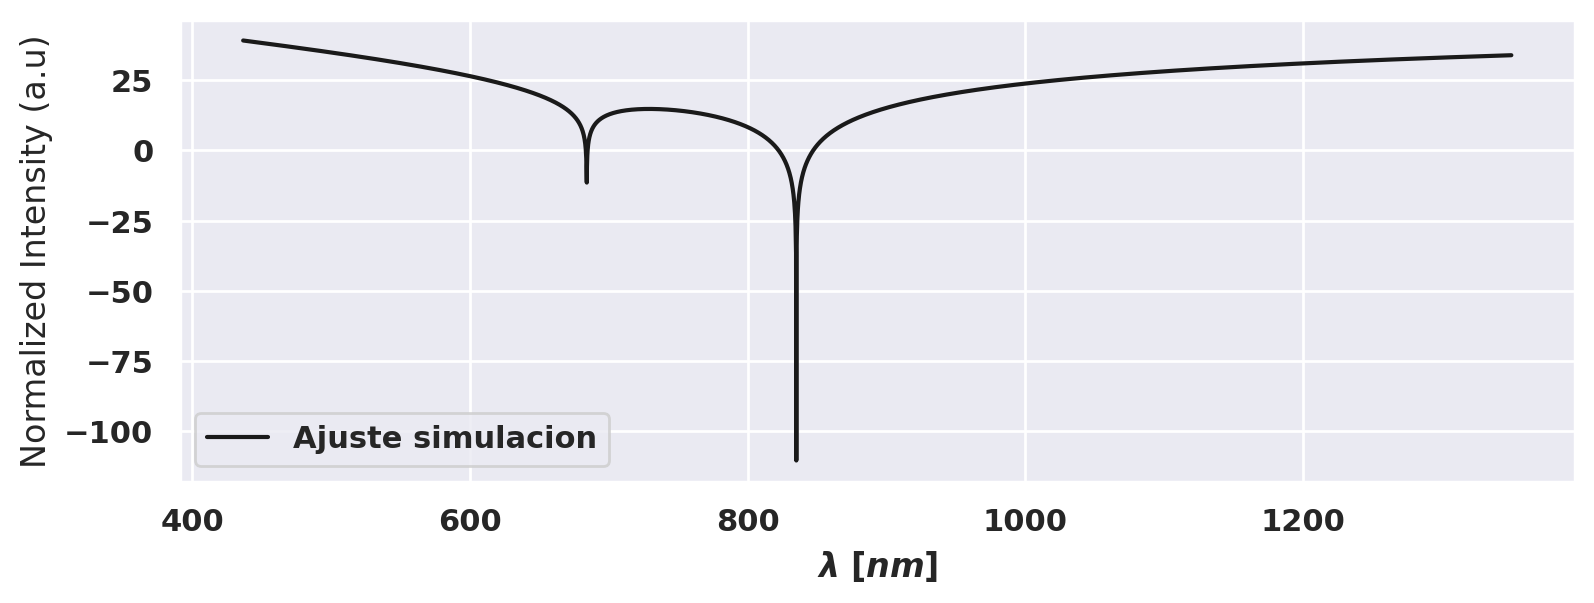

In [15]:
#Constants
n = 2**13    # number of grid points
TimeWindow = 12.5e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow/2,TimeWindow/2,dT) #  time grid
#Laser parameters
WaveLength=1550e-9      #reference wavelength [m]
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
nu=100e6 #Repetition rate (Hz)
t0 =200e-15       # duration of input [s]
power = 80e-3/(nu*t0)        #peak power of input [W]
A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
AW=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))*TimeWindow

f = plt.figure(figsize=(9, 3),dpi=200)
yy,lam=propagar_lab()
N1=400 ;N2=1350
WL=lam*1e9
iis=np.array([(i>N1 and i<N2) for i in WL])
In1=yy.y[iis,-1]

lam=WL[iis]
#plt.plot(lam,np.abs(AW[iis])**2/max(np.abs(AW)**2),'ko',label='tEORICO')
plt.plot(lam,10*np.log10(np.abs(In1)),'k',label='Ajuste simulacion')
#plt.xlim(-1,1)
#plt.plot(Wave_new,Power_new,'o',label='Thorlabs')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (a.u)' )
#plt.xlim(1300,1800)
plt.legend()


# Método 2.

In [45]:
c = 299792458; 

def convft(f1,f2,dx):
    """

    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    F1=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f1)))
    F2=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f2)))
    U2=F2*F1
    conv=np.fft.fftshift(np.fft.fft(np.fft.fftshift(U2)))
    return conv


c = 299792458;    
def propagar():


    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    c = 299792458;            #speed of light [m/s]
    wavelength = 835e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/wavelength  #reference frequency [Hz]
    dT =  TimeWindow /n
    TimeGrid =  np.arange(- TimeWindow /2, TimeWindow /2,dT) #  time grid
    power = 100            #peak power of input [W]
    t0 =28.4e-15       # duration of input [s]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/t0) # input field [W^(1/2)]
    length = 0.15             #ibre length [m]
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    betas = [-1.1830e-26, 8.1038e-41, -9.5205e-56,  2.0737e-70,
    -5.3943e-85,  1.3486e-99, -2.5495e-114,  3.0524e-129, 
    -1.7140e-144]
    gamma = 0.11    #nonlinear coefficient [1/W/m]
    loss = 0        #loss [dB/m]
   
    fr = 0.18                  # fractional Raman contribution

    tau1 = 18e-15; tau2 = 32e-15;

    RT=((tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1))
       #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))# Response function
       
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    f_minn=1/(2*dT)

    V=2*np.pi*np.arange(-f_minn, f_minn,1/(dT*n)) # frequency grid

    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2
   
    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid


    #Ecuación a integrar.
    def rhs(z,AW):
        AT=np.fft.fftshift(np.fft.fft(np.fft.fftshift(AW*np.exp(L*z))))
        IT=np.abs(AT)**2
        term_1=(1-fr)*IT
        term_2=fr*convft(hr*n,IT,TimeWindow)*dT     
        M=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(AT*(term_1+term_2))))
        return 1j*W*gamma/w0**np.exp(-L*z)*M

    nsaves=200  # Number of points along the distance

    # Z 
    z = np.linspace(0,length,nsaves)

    AW=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))
    AW=AW.astype('complex')
  
    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],AW,Wmethod="DOP853",t_eval=z)


    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid


    for i in range(0,len(y.y[0,:])):
        y.y[:,i] = y.y[:,i]*np.exp(L*z[i])*TimeWindow# change variables, frequency solutions.
        
    
   
    return y,WL
   
    


def Delta_landa1(y_data,x_data):
    cs=CubicSpline(x_data,y_data)
    new_xdata=np.linspace(min(x_data),max(x_data),len(x_data)*3)
    Y=cs(new_xdata)
    medium_value=np.max(Y)*0.01
    M_V=[]
    wl_s=[]
    pow_s=[]
    
    for i in range(len(Y)):
        if Y[i]>medium_value:
            
            M_V.append(i)
            wl_s.append(new_xdata[i])
            pow_s.append(Y[i])
            

    x1=new_xdata[np.min(M_V)]; 
    x2=new_xdata[np.max(M_V)]
    return abs(x2-x1)

  



In [46]:
yy,lam=propagar()

#plt.plot(lam,np.abs(AW[iis])**2/max(np.abs(AW)**2),'ko',label='tEORICO')


/usr/lib/python3/dist-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `Wmethod`.
  warn("The following arguments have no effect for a chosen solver: {}."
/tmp/ipykernel_28084/857423821.py:81: RuntimeWarning: overflow encountered in square
  IT=np.abs(AT)**2
/tmp/ipykernel_28084/857423821.py:25: RuntimeWarning: invalid value encountered in multiply
  U2=F2*F1
/tmp/ipykernel_28084/857423821.py:85: RuntimeWarning: overflow encountered in multiply
  return 1j*W*gamma/w0**np.exp(-L*z)*M
/tmp/ipykernel_28084/857423821.py:85: RuntimeWarning: invalid value encountered in multiply
  return 1j*W*gamma/w0**np.exp(-L*z)*M


In [14]:

n = 2**13    # number of grid points
TimeWindow = 12.5e-12 # width of time window [s]     
c = 299792458;            #speed of light [m/s]
wavelength = 835e-9      #reference wavelength [m]
w0 = (2*np.pi*c)/wavelength  #reference frequency [Hz]
dT =  TimeWindow /n
TimeGrid =  np.arange(- TimeWindow /2, TimeWindow /2,dT) #  time grid
power = 10000            #peak power of input [W]
t0 =28.4e-15       # duration of input [s]
A = np.sqrt(power)*1/np.cosh(TimeGrid/t0) # input field [W^(1/2)]
func_F=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))*TimeWindow

In [ ]:

#plt.xlim(-1,1)
plt.plot(lam,esc,'k',label='Ajuste simulacion')
plt.plot(lam,10*np.log10(np.abs(func_F[iis])**2),'r',label='Inicial')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (a.u)' )
#plt.xlim(1300,1800)
plt.legend()

# Método 3

In [41]:
def propagarr():
    #Constants
    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    dT = TimeWindow/n
    T =  np.arange(-n/2,n/2,1)*dT #  time grid
    
    #Laser parameters
    WaveLength=1550e-9      #reference wavelength [m]
    global w0 
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
    nu=100e6 #Repetition rate (Hz)
    t0 =200e-15       # duration of input [s]
    power = 80e-3/(nu*t0)        #peak power of input [W]
    A = np.sqrt(power)*1/np.cosh(T/(t0/2.634)) # input field [W^(1/2)]
  
    #Fiber parameters 
    length = 1.0             #ibre length [m]
    D=-1.0*1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    beta2=-WaveLength**2/(2*np.pi*c)*D
    beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
    betas=[beta2,beta3]
    gamma = 10.8*1e-3    #nonlinear coefficient [1/
    #Raman response
    fr = 0.18                  # fractional Raman contribution
    tau1 = 0.0122e-12; tau2 = 0.032e-12;
    loss = 0.1e-3       #loss [dB/m]

    RT=(tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-T/tau2)*np.sin(T/tau1) # Response function
    RT[T<0]=0

    hr=RT/np.trapz(RT, T)

    fw =np.fft.ifft((A))

    n = len(T); dT = T[2]-T[1]

    V=2*np.pi*np.arange(-n/2,n/2,1).T/(n*dT)  # frequency grid

    alpha = np.log(10.**(loss/10))   #attenuation coefficient

    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2

    gamma = gamma/w0   

    W = V + w0  

    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman

    L=np.fft.fftshift(L) 

    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):
            
        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE
        
        IT=np.abs(AT)**2
        
        AA=np.fft.ifft(IT) #Fourier transform of IT
            
        RS= fr*np.fft.fft(HW*AA)*dT # Convolution
        
        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function
                
        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=200  # Number of points along the distance

    # Z
    z = np.linspace(0,length,nsaves)

    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,method="DOP853",t_eval=z)
    for i in range(0,len(y.y[0,:])):
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n # change variables, frequency solutions.
    
    W = V + w0  
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    return y,WL




In [42]:
yy,lam=propagarr()

#plt.plot(lam,np.abs(AW[iis])**2/max(np.abs(AW)**2),'ko',label='tEORICO')


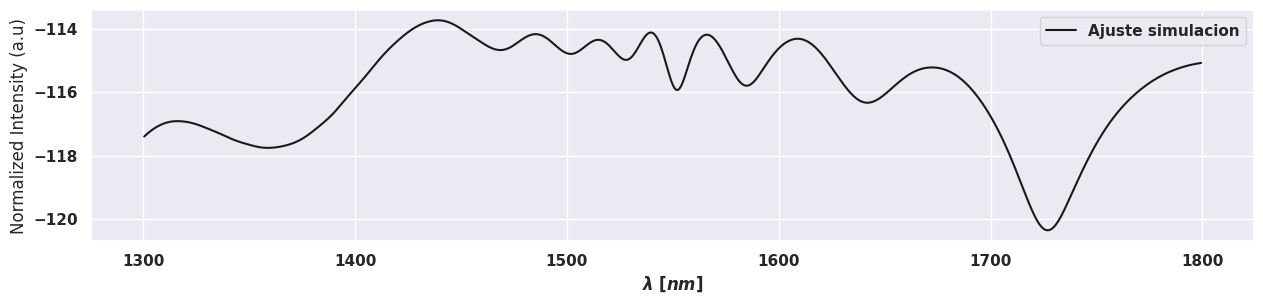

In [43]:
fig=plt.figure(figsize=(15,3))
N1=1300 ;N2=1800
WL=lam*1e9
iis=np.array([(i>N1 and i<N2) for i in WL])
In1=yy.y[iis,-1]

lam=WL[iis]
#plt.plot(lam,np.abs(AW[iis])**2/max(np.abs(AW)**2),'ko',label='tEORICO')
plt.plot(lam,10*np.log10(np.abs(In1)),'k',label='Ajuste simulacion')
#plt.xlim(-1,1)
#plt.plot(Wave_new,Power_new,'o',label='Thorlabs')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (a.u)' )
#plt.xlim(1300,1800)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


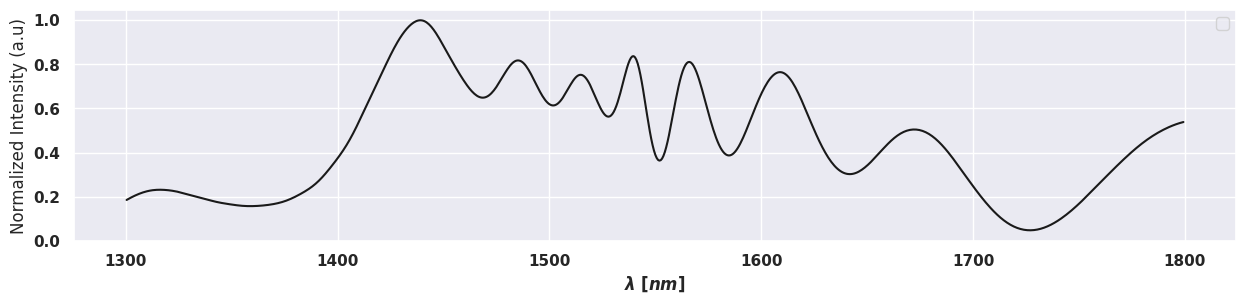

In [44]:
fig=plt.figure(figsize=(15,3))
plt.plot(lam,np.abs(In1)**2/max(np.abs(In1)**2),'k')
#plt.xlim(-1,1)
#plt.plot(Wave_new,Power_new,'o',label='Thorlabs')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (a.u)' )
#plt.xlim(1300,1800)
plt.legend()

# Método 4.

In [16]:
c = 299792458; 

def convft(f1,f2,dx):
    """

    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    F1=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f1)))
    F2=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f2)))
    U2=F2*F1
    conv=np.fft.fftshift(np.fft.fft(np.fft.fftshift(U2)))*dx
    return conv


c = 299792458;    
def propagar():


    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    c = 299792458;            #speed of light [m/s]
    wavelength = 835e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/wavelength  #reference frequency [Hz]
    dT =  TimeWindow /n
    TimeGrid =  np.arange(- TimeWindow /2, TimeWindow /2,dT) #  time grid
    power = 10000            #peak power of input [W]
    t0 =28.4e-15       # duration of input [s]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/t0) # input field [W^(1/2)]
    length = 0.15             #ibre length [m]
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    betas = [-1.1830e-26, 8.1038e-41, -9.5205e-56,  2.0737e-70,
    -5.3943e-85,  1.3486e-99, -2.5495e-114,  3.0524e-129, 
    -1.7140e-144]
    gamma = 0.11    #nonlinear coefficient [1/W/m]
    loss = 0        #loss [dB/m]
   
    fr = 0.18                  # fractional Raman contribution

    tau1 = 18e-15; tau2 = 32e-15;

    RT=((tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1))
       #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))# Response function
       
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT,TimeGrid)
    f_minn=1/(2*dT)

    V=2*np.pi*np.arange(-f_minn, f_minn,1/(dT*n)) # frequency grid
    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2
   
    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid

    #Ecuación a integrar.
    def rhs(z,AW):
        AT=np.fft.fftshift(np.fft.fft(np.fft.fftshift(AW*np.exp(L*z))))/TimeWindow
        IT=np.abs(AT)**2
        term_1=(1-fr)*IT
        term_2=fr*convft(hr,IT,TimeWindow)  
        M=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(AT*(term_1+term_2))))*TimeWindow
        return 1j*W[i]*gamma/w0**np.exp(-L*z)*M


    nsaves=10  # Number of points along the distance
    z = np.linspace(0,length,nsaves)
    AW=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))*TimeWindow
    AW=AW.astype('complex')
    deltaz=len(z)/nsaves
    sol=[]

    for i in range(0,len(AW)):

        A_ij=AW
        for j in range(0,len(z)):
            A_imj=A_ij+deltaz*rhs(z[j],A_ij)
            A_ij=A_imj
            
    
    sol.append(A_ij)
    
    sol=np.array(sol)*np.exp(L*z[-1])


    WL = (2*np.pi*c/W) 
        
    return sol,WL
   
    



  



In [27]:
yy,lam=propagar()

/tmp/ipykernel_65275/21289842.py:82: RuntimeWarning: overflow encountered in multiply
  M=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(AT*(term_1+term_2))))*TimeWindow
/tmp/ipykernel_65275/21289842.py:82: RuntimeWarning: invalid value encountered in multiply
  M=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(AT*(term_1+term_2))))*TimeWindow
/tmp/ipykernel_65275/21289842.py:26: RuntimeWarning: invalid value encountered in multiply
  conv=np.fft.fftshift(np.fft.fft(np.fft.fftshift(U2)))*dx
/tmp/ipykernel_65275/21289842.py:81: RuntimeWarning: invalid value encountered in multiply
  term_2=fr*convft(hr,IT,TimeWindow)
/tmp/ipykernel_65275/21289842.py:25: RuntimeWarning: overflow encountered in multiply
  U2=F2*F1
/tmp/ipykernel_65275/21289842.py:25: RuntimeWarning: invalid value encountered in multiply
  U2=F2*F1
/tmp/ipykernel_65275/21289842.py:79: RuntimeWarning: overflow encountered in square
  IT=np.abs(AT)**2


ValueError: x and y must have same first dimension, but have shapes (801,) and (5701,)

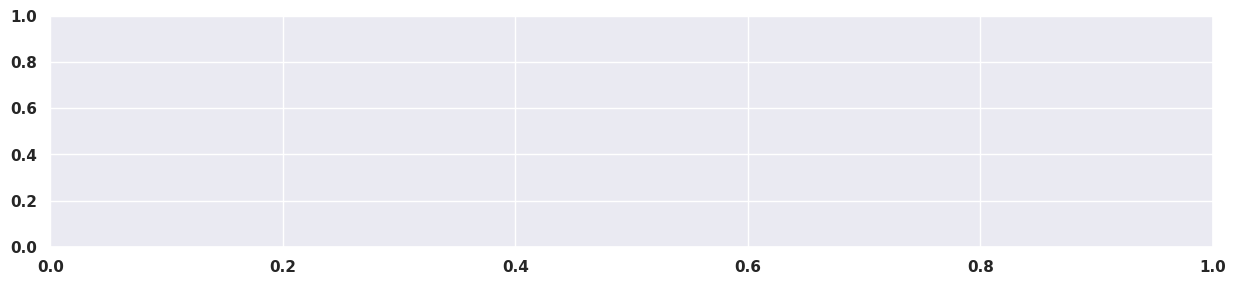

In [29]:
fig=plt.figure(figsize=(15,3))
N1=400;N2=1300
WL=lam*1e9
iis=np.array([(i>N1 and i<N2) for i in WL])
In1=yy[0][iis]
WL=WL[iis]
plt.plot(aa,10*np.log10(np.abs(In1)),'k',label='Ajuste simulacion')
plt.xlabel('$\lambda$ $[nm]$')
plt.ylabel('Normalized Intensity (a.u)' )
plt.legend()

In [33]:
In1

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

# Example Fourier transform

/home/esteban/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


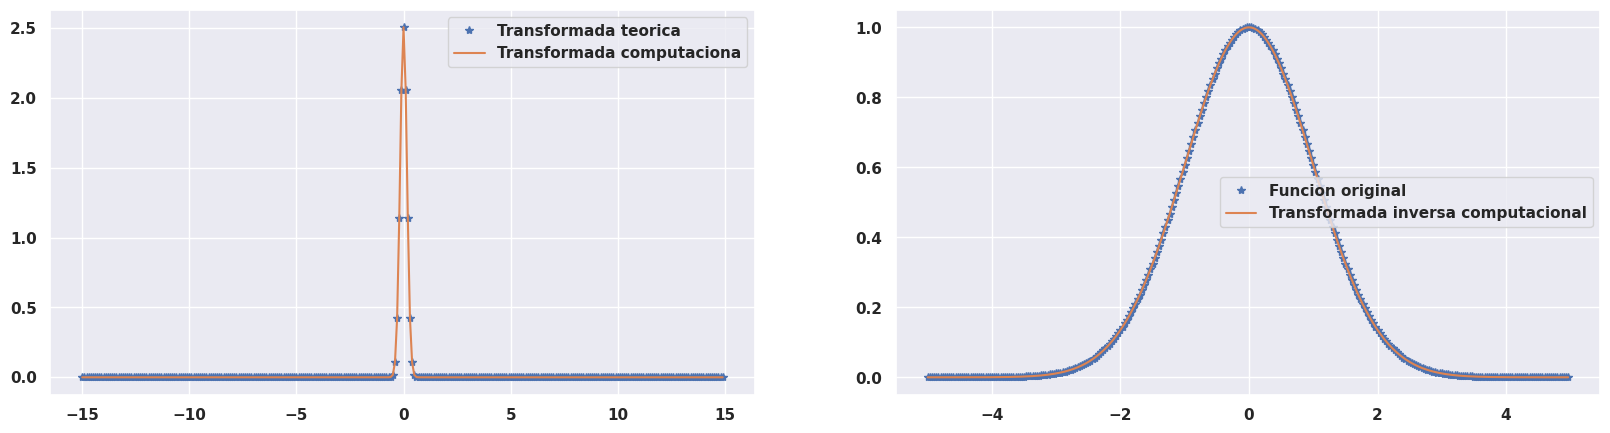

In [3]:
L=10
M=300
a=1
dx=L/M
x=np.arange(-L/2,L/2,dx)
y=lambda x: np.exp(-a*x**2/2)
func=y(x)
func_F=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(func)))*L

f_min=1/(2*dx)
freq=np.arange(-f_min,f_min,1/(dx*x.size))
func_FR=np.sqrt((2*np.pi/a))*np.exp(-(2*np.pi*freq)**2/(2*a))
func_iF=np.fft.fftshift(np.fft.fft(np.fft.fftshift(func_FR)))*1/(L)


f=plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(freq,func_FR,'*',label="Transformada teorica")
plt.plot(freq,func_F,label="Transformada computaciona")
plt.legend()

plt.subplot(122)
plt.plot(x,func,'*',label="Funcion original")
plt.plot(x,func_iF,label="Transformada inversa computacional")
plt.legend()


# Convolution

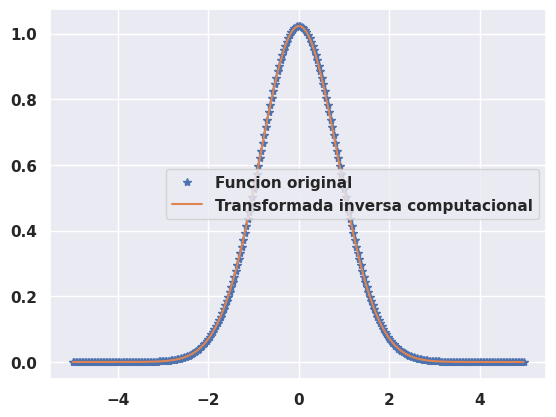

In [4]:
L=10
M=300
a=1
b=2
dx=L/M
x=np.arange(-L/2,L/2,dx)
y1=np.exp(-a*x**2)
y2=np.exp(-b*x**2)
conv_t=np.sqrt(np.pi/(a+b))*np.exp(-a*b/(a+b)*x**2)
conv_c=convft(y1,y2,L)

plt.plot(x,conv_t,'*',label="Funcion original")
plt.plot(x,conv_c,label="Transformada inversa computacional")
plt.legend()